# Porject code

## Model 1

### Summary for Model 1

After choosing a z-slice and normalizing intensities, the three movies share the same spatial resolution 256×256 with different time lengths.

We build samples using a sliding temporal window with K = 4 time steps, C = 1 channel, H = 256 W = 256 spatial dimensions.

Combining all windows from the three movies yields 82 samples in total. We then plit them into train, validation, test sets as 57, 12, 13.

We formulate the task as predicting the next frame given the previous 4 frames, which is a a supervised nonlinear regression problem at the pixel level. If the model can accurately reconstruct future intensity patterns, it has captured local motion and brightness changes of Dicty cells.

We choose a compact 3D CNN, and use MSE as the loss, which directly measures the discrepancy between predicted and true intensities at each pixel. A lower MSE means the model better reconstructs cell distributions and potential aggregation regions.

To expose the model to more diverse dynamics, we merge all three movies into a single training dataset, which can improve generalization to unseen experiments.

In [2]:
!pip install zarr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 94.9 MB/s eta 0:00:00


In [3]:
# Setup

import os, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import zarr


def set_seed(seed=7):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
set_seed(7)

try:
    from google.colab import drive
    drive.mount("/content/drive")
    BASE_DIR = "/content/drive/MyDrive/5243 project2"
except ImportError:
    BASE_DIR = "/path/to/5243 project2"

print("BASE_DIR:", BASE_DIR)

MOVIES = {
    "m44": os.path.join(
        BASE_DIR,
        "mixin_test44",
        "2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr",
    ),
    "m57": os.path.join(
        BASE_DIR,
        "mixin_test57",
        "2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr",
    ),
    "m64": os.path.join(
        BASE_DIR,
        "mixin_test64",
        "ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr",
    ),
}
MOVIES


Device: cuda
Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/5243 project2


{'m44': '/content/drive/MyDrive/5243 project2/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr',
 'm57': '/content/drive/MyDrive/5243 project2/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr',
 'm64': '/content/drive/MyDrive/5243 project2/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr'}

raw zarr shape: (34, 1, 32, 256, 256),  chosen z_index=16
raw zarr shape: (40, 1, 16, 256, 256),  chosen z_index=8
raw zarr shape: (20, 1, 48, 256, 256),  chosen z_index=24
Movie 0: shape (34, 256, 256)
Movie 1: shape (40, 256, 256)
Movie 2: shape (20, 256, 256)
movie shape: (34, 256, 256) min/max: 0.0 1.0
Using frame indices: [ 0 11 22 33]


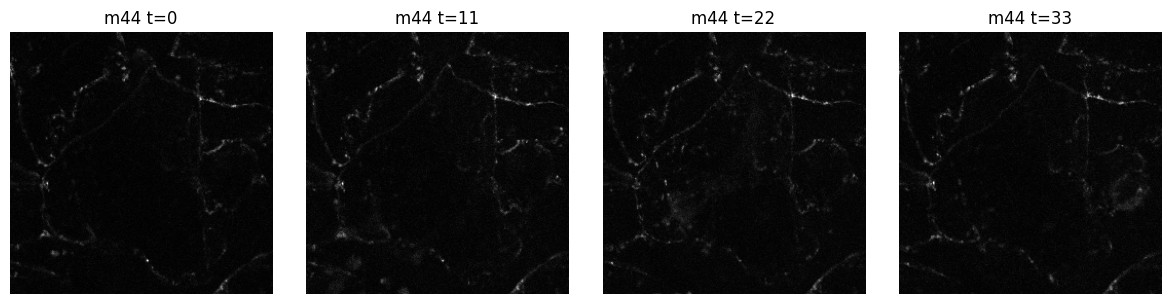

In [4]:
# Load zarr movies & visualize

def load_zarr_movie(zarr_path, z_index=None, channel=0, normalize=True):
    store = zarr.open(zarr_path, mode="r")
    arr = np.array(store)

    if arr.ndim == 5:
        T, C, Z, H, W = arr.shape
    elif arr.ndim == 4:
        T, Z, H, W = arr.shape
        C = 1
        arr = arr[:, None, :, :, :]
    else:
        raise ValueError(f"Unexpected ndim {arr.ndim}, expected 4 or 5")

    if z_index is None or not (0 <= z_index < Z):
        z_index = Z // 2

    movie = arr[:, channel, z_index, :, :]

    if normalize:
        movie = movie.astype(np.float32)
        movie = (movie - movie.min()) / (movie.max() - movie.min() + 1e-8)

    print(f"raw zarr shape: {arr.shape},  chosen z_index={z_index}")
    return movie


def show_frames(movie, n_frames=4, title_prefix=""):
    T = movie.shape[0]
    idx = np.linspace(0, T-1, n_frames, dtype=int)
    print("movie shape:", movie.shape, "min/max:", movie.min(), movie.max())
    print("Using frame indices:", idx)

    fig, axes = plt.subplots(1, n_frames, figsize=(3*n_frames, 3))
    for ax, t in zip(axes, idx):
        ax.imshow(movie[t], cmap="gray")
        ax.set_title(f"{title_prefix} t={t}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


movie44 = load_zarr_movie(MOVIES["m44"], z_index=None)
movie57 = load_zarr_movie(MOVIES["m57"], z_index=None)
movie64 = load_zarr_movie(MOVIES["m64"], z_index=None)

movies = [movie44, movie57, movie64]
for i, m in enumerate(movies):
    print(f"Movie {i}: shape {m.shape}")

show_frames(movie44, title_prefix="m44")


In [5]:
# sliding window dataset
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

movies = [movie44, movie57, movie64]

print("Movie shapes:")
for i, m in enumerate(movies):
    print(f"  Movie {i}: {m.shape}, min={m.min():.3f}, max={m.max():.3f}")

class MultiMovieWindows(Dataset):
    def __init__(self, movies, K=4, stride=1):
        self.movies = movies
        self.K = K
        self.index = []

        for m_idx, mov in enumerate(self.movies):
            T = mov.shape[0]
            for t0 in range(0, T - K, stride):
                self.index.append((m_idx, t0))
        print(f"Total sliding windows in dataset: {len(self.index)}")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        m_idx, t0 = self.index[idx]
        mov = self.movies[m_idx]
        K = self.K

        x = mov[t0 : t0 + K]
        y = mov[t0 + K]
        x = torch.from_numpy(x[:, None, :, :])
        y = torch.from_numpy(y[None, :, :])

        return x.float(), y.float()



K = 4
ds = MultiMovieWindows(movies, K=K, stride=1)

x0, y0 = ds[0]
print("One sample x shape:", x0.shape, "y shape:", y0.shape)



n_total = len(ds)
n_tr = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_te = n_total - n_tr - n_val

g = torch.Generator().manual_seed(0)
tr_ds, val_ds, te_ds = random_split(ds, [n_tr, n_val, n_te], generator=g)
print(f"Split sizes -> train: {len(tr_ds)}, val: {len(val_ds)}, test: {len(te_ds)}")

BATCH_SIZE = 16
tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
te_loader  = DataLoader(te_ds, batch_size=BATCH_SIZE, shuffle=False)

xb, yb = next(iter(tr_loader))
print("Batch x shape:", xb.shape, "Batch y shape:", yb.shape)


Movie shapes:
  Movie 0: (34, 256, 256), min=0.000, max=1.000
  Movie 1: (40, 256, 256), min=0.000, max=1.000
  Movie 2: (20, 256, 256), min=0.000, max=1.000
Total sliding windows in dataset: 82
One sample x shape: torch.Size([4, 1, 256, 256]) y shape: torch.Size([1, 256, 256])
Split sizes -> train: 57, val: 12, test: 13
Batch x shape: torch.Size([16, 4, 1, 256, 256]) Batch y shape: torch.Size([16, 1, 256, 256])


epoch 01 | train MSE=0.00345 | val MSE=0.00146
epoch 05 | train MSE=0.00067 | val MSE=0.00046
epoch 10 | train MSE=0.00017 | val MSE=0.00016
epoch 15 | train MSE=0.00016 | val MSE=0.00015
epoch 20 | train MSE=0.00014 | val MSE=0.00014
epoch 25 | train MSE=0.00014 | val MSE=0.00013
epoch 30 | train MSE=0.00013 | val MSE=0.00013
test MSE = 0.00013


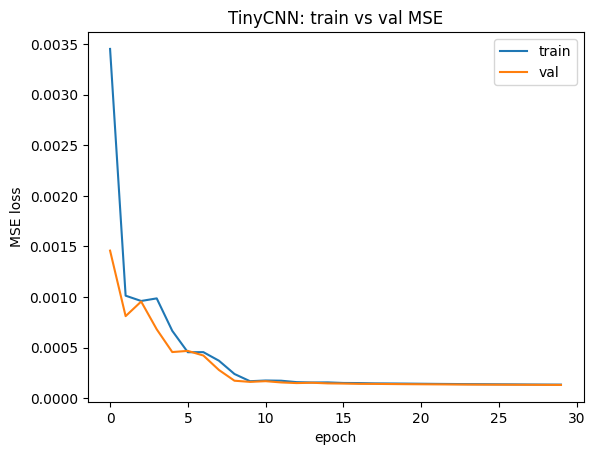

In [6]:
# Conv3D encoder - Conv2D head
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class TinyCNN(nn.Module):
    def __init__(self, K: int):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(
                in_channels=1,
                out_channels=8,
                kernel_size=(K, 3, 3),
                padding=(0, 1, 1)
            ),
            nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        z = self.enc(x).squeeze(2)
        out = self.head(z)
        return out

model1 = TinyCNN(K).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-5)

def train_epoch(model, loader):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

n_epochs = 30
hist_tr, hist_val = [], []

for ep in range(1, n_epochs + 1):
    tr = train_epoch(model1, tr_loader)
    va = evaluate(model1, val_loader)
    hist_tr.append(tr)
    hist_val.append(va)

    if ep == 1 or ep % 5 == 0:
        print(f"epoch {ep:02d} | train MSE={tr:.5f} | val MSE={va:.5f}")

test_mse = evaluate(model1, te_loader)
print(f"test MSE = {test_mse:.5f}")

plt.figure()
plt.plot(hist_tr, label="train")
plt.plot(hist_val, label="val")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("TinyCNN: train vs val MSE")
plt.legend()
plt.show()


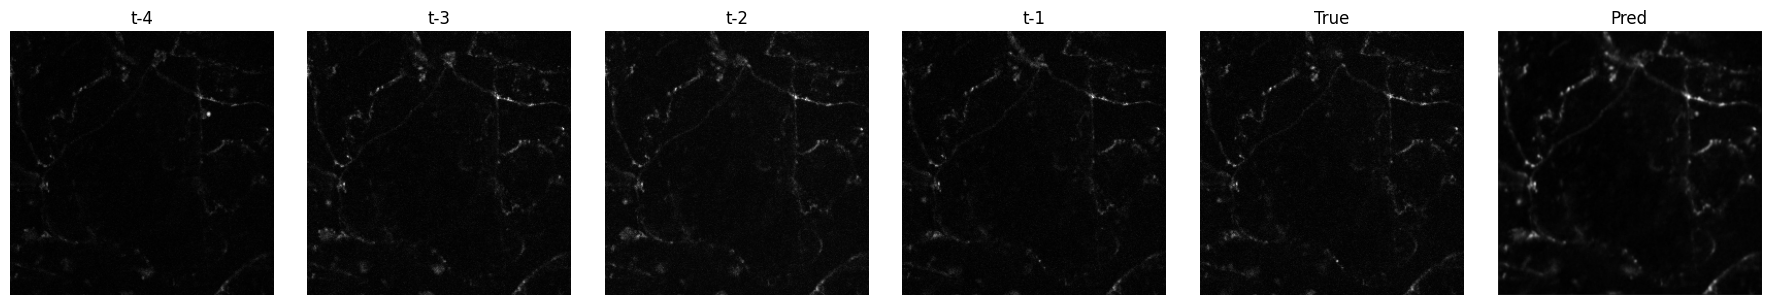

In [7]:
# Qualitative example

import numpy as np

@torch.no_grad()
def show_example(dataset, model, idx=0, K=4):
    xb, yb = dataset[idx]
    xb_in = xb.unsqueeze(0).to(DEVICE)
    pred = model(xb_in).cpu().squeeze(0).squeeze(0).numpy()
    true = yb.numpy().squeeze(0)

    hist = xb.numpy()[:, 0, :, :]
    cols = K + 2
    fig, axs = plt.subplots(1, cols, figsize=(3 * cols, 3))

    for i in range(K):
        axs[i].imshow(hist[i], cmap="gray")
        axs[i].set_title(f"t-{K-i}")
        axs[i].axis("off")

    axs[-2].imshow(true, cmap="gray")
    axs[-2].set_title("True")
    axs[-2].axis("off")

    axs[-1].imshow(pred, cmap="gray")
    axs[-1].set_title("Pred")
    axs[-1].axis("off")

    plt.tight_layout()
    plt.show()

show_example(ds, model1, idx=5, K=K)


### Outputs for Model 1

Training MSE decreases from about 3.5×10⁻³ to 1.3×10⁻⁴. Validation MSE drops from 1.5×10⁻³ to 1.3×10⁻⁴ and closely tracks the training curve, indicating no severe overfitting. Final test MSE ≈ 1.3×10⁻⁴, which is small relative to the [0,1] intensity range.

The predicted frame matches the true frame very well at the global level and is slightly smoother than the ground truth. For the aggregation task, potential high intensity aggregation regions are still present in the prediction, indicating that the model has captured meaningful motion and intensity trends.

Overall, Model 1 converges stably on all three movies, with similar train, val, and test MSE, suggesting good fit and generalization for this compact 3D CNN.

## Model 2

### Summary for Model 2

In Model 2, we merge the three subsampled zarr movies into a single joint dataset. For each movie we select one z-slice and the red channel, and normalize intensities to
[0,1]. Then we build samples using a sliding temporal window of K2 = 8 frames. Each input x has shape (8, 1, 256, 256), which means 8 consecutive frames, one channel, 256×256 spatial resolution. Across the three movies this gives 70 sliding windows, split into 49 train, 10 validation, and 11 test samples.

Model 1 used only 4 frames. In Model 2 we increase the window length to 8 frames, so that the model can see a longer motion history.

We still use the full frame at time t+1 as the regression target, and keep the TinyCNN structure. We use MSELoss as a  regression loss, measuring the squared error between predicted and true frames over all pixels. This is compatible with overall MSE and center error.

In [8]:
# longer temporal window K = 8
K2 = 8

ds2 = MultiMovieWindows(movies, K=K2, stride=1)

x2, y2 = ds2[0]
print("K2 =", K2)
print("One sample x2 shape:", x2.shape, "y2 shape:", y2.shape)

n_total = len(ds2)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

train2_ds, val2_ds, test2_ds = torch.utils.data.random_split(
    ds2, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(0)
)

print(f"Split sizes (K2): train={len(train2_ds)}, val={len(val2_ds)}, test={len(test2_ds)}")

BATCH_SIZE2 = 16

train2_loader = DataLoader(train2_ds, batch_size=BATCH_SIZE2, shuffle=True)
val2_loader   = DataLoader(val2_ds,   batch_size=BATCH_SIZE2, shuffle=False)
test2_loader  = DataLoader(test2_ds,  batch_size=BATCH_SIZE2, shuffle=False)

bx2, by2 = next(iter(train2_loader))
print("Batch x2 shape:", bx2.shape, "Batch y2 shape:", by2.shape)


Total sliding windows in dataset: 70
K2 = 8
One sample x2 shape: torch.Size([8, 1, 256, 256]) y2 shape: torch.Size([1, 256, 256])
Split sizes (K2): train=49, val=10, test=11
Batch x2 shape: torch.Size([16, 8, 1, 256, 256]) Batch y2 shape: torch.Size([16, 1, 256, 256])


TinyCNN(
  (enc): Sequential(
    (0): Conv3d(1, 8, kernel_size=(8, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (head): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)
[Model2 K=8] epoch 01 | train MSE=0.01425 | val MSE=0.00720
[Model2 K=8] epoch 05 | train MSE=0.00190 | val MSE=0.00240
[Model2 K=8] epoch 10 | train MSE=0.00043 | val MSE=0.00033
[Model2 K=8] epoch 15 | train MSE=0.00020 | val MSE=0.00021
[Model2 K=8] epoch 20 | train MSE=0.00018 | val MSE=0.00016
[Model2 K=8] epoch 25 | train MSE=0.00018 | val MSE=0.00016
[Model2 K=8] epoch 30 | train MSE=0.00017 | val MSE=0.00016
[Model2 K=8] test MSE = 0.00016


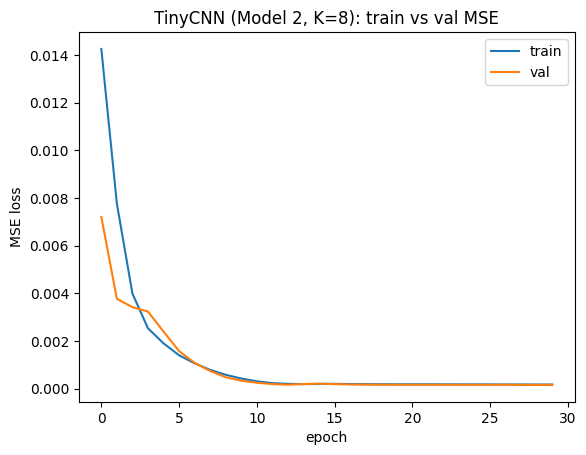

In [9]:
# CNN

model2 = TinyCNN(K2).to(DEVICE)
loss_fn2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-5)

print(model2)

loss_fn2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-5)

def train_epoch2(model, loader):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer2.zero_grad()
        pred = model(xb)
        loss = loss_fn2(pred, yb)
        loss.backward()
        optimizer2.step()

        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate2(model, loader):
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn2(pred, yb)
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)


n_epochs2 = 30
hist_tr2, hist_val2 = [], []

for ep in range(1, n_epochs2 + 1):
    tr2 = train_epoch2(model2, train2_loader)
    va2 = evaluate2(model2, val2_loader)
    hist_tr2.append(tr2)
    hist_val2.append(va2)

    if ep == 1 or ep % 5 == 0:
        print(f"[Model2 K={K2}] epoch {ep:02d} | train MSE={tr2:.5f} | val MSE={va2:.5f}")

test_mse2 = evaluate2(model2, test2_loader)
print(f"[Model2 K={K2}] test MSE = {test_mse2:.5f}")


plt.figure()
plt.plot(hist_tr2, label="train")
plt.plot(hist_val2, label="val")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title(f"TinyCNN (Model 2, K={K2}): train vs val MSE")
plt.legend()
plt.show()

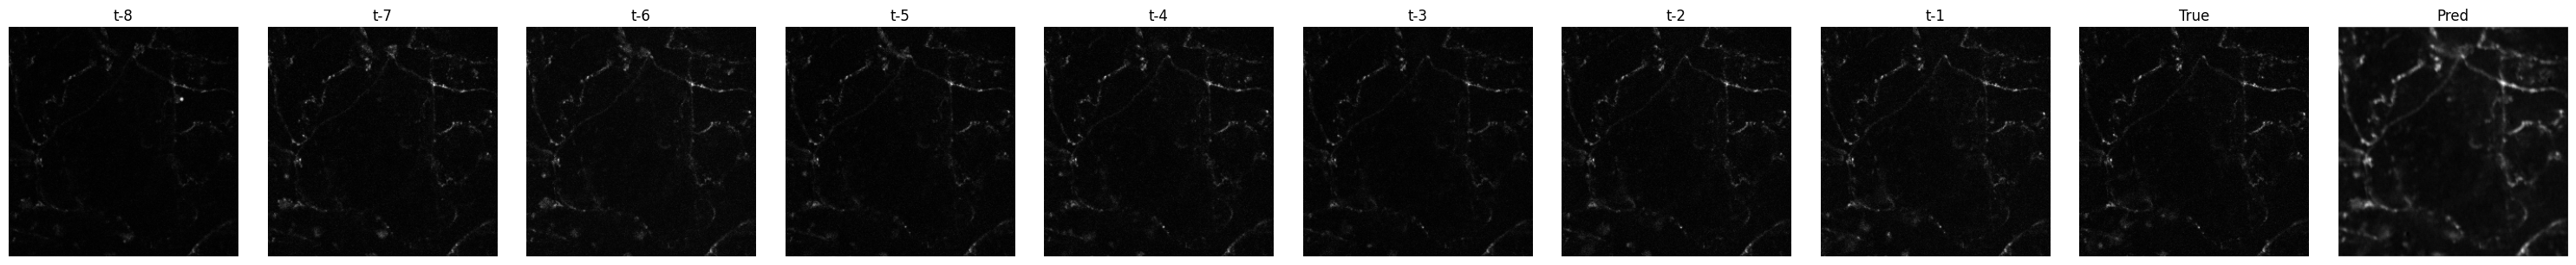

In [10]:
@torch.no_grad()
def evaluate2(model, loader):
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn2(pred, yb)
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

show_example(ds2, model2, idx=5, K=K2)

### Outputs for Model 2

For Model 2, both training and validation losses decrease smoothly. Training MSE drops from about 4.5×10⁻² to 1.7×10⁻⁴. Validation MSE decreases from 3.3×10⁻² to 1.5×10⁻⁴, and it stays close to the training curve, with no sign of strong overfitting or divergence. On the test set, the model reaches test MSE ≈ 1.6×10⁻⁴, which is on the same order as Model 1.

The predicted frame reproduces the global bright–dark pattern and main structures of the ground-truth image. Fine details are slightly smoother.

In general, given 8 frames of motion history, Model 2 can  reconstruct the high intensity regions in the next frame, providing a solid baseline from which we can later extract aggregation centers and compute metrics.

## Model 3

### Summary for Model 3

Target y3 has shape (1, 256, 256) and represents the velocity map y(t)=frame[t+1]−frame[t]. So Model 3 is about given 8 past frames, predict a pixel-wise velocity field and then reconstruct frame[t+1]=frame[t]+v.

we reuse the TinyCNN and increase K from 4 to 8. For the velocity target we use L1 loss rather than MSE, because velocity maps are mostly near zero with a few large changes, and L1 is more robust to rare large errors and better suited to sparse changes. The three movies are merged and turned into 70 sliding windows, with train 49, val 10, test 11.


In [11]:
# L1 / MAE loss + early stopping

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import copy
import matplotlib.pyplot as plt

K3 = 8

ds3 = MultiMovieWindows(movies, K=K3, stride=1)

x3, y3 = ds3[0]
print("One sample x3 shape:", x3.shape, "y3 shape:", y3.shape)

N = len(ds3)
n_train = int(0.7 * N)
n_val = int(0.15 * N)
n_test = N - n_train - n_val

print(f"Total sliding windows (K3): {N}")
print(f"Split sizes (K3): train={n_train}, val={n_val}, test={n_test}")

g = torch.Generator().manual_seed(0)
tr_ds3, val_ds3, te_ds3 = random_split(ds3, [n_train, n_val, n_test], generator=g)

BATCH_SIZE3 = 16
tr_loader3 = DataLoader(tr_ds3, batch_size=BATCH_SIZE3, shuffle=True)
val_loader3 = DataLoader(val_ds3, batch_size=BATCH_SIZE3, shuffle=False)
te_loader3 = DataLoader(te_ds3, batch_size=BATCH_SIZE3, shuffle=False)

xb3, yb3 = next(iter(tr_loader3))
print("Batch x3 shape:", xb3.shape, "Batch y3 shape:", yb3.shape)

Total sliding windows in dataset: 70
One sample x3 shape: torch.Size([8, 1, 256, 256]) y3 shape: torch.Size([1, 256, 256])
Total sliding windows (K3): 70
Split sizes (K3): train=49, val=10, test=11
Batch x3 shape: torch.Size([16, 8, 1, 256, 256]) Batch y3 shape: torch.Size([16, 1, 256, 256])


In [12]:
# CNN

class TinyCNN(nn.Module):
    def __init__(self, K: int):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(
                in_channels=1,
                out_channels=8,
                kernel_size=(K, 3, 3),
                padding=(0, 1, 1)
            ),
            nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        z = self.enc(x).squeeze(2)
        out = self.head(z)
        return out

model3 = TinyCNN(K3).to(DEVICE)

loss_fn3 = nn.L1Loss()
optimizer3 = optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-5)

In [13]:
# velocity with L1 loss

def train_epoch_vel(model, loader):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        last_frame = xb[:, -1, 0, :, :].unsqueeze(1)
        target_vel = yb - last_frame

        optimizer3.zero_grad()
        pred_vel = model(xb)  # (B, 1, H, W)
        loss = loss_fn3(pred_vel, target_vel)
        loss.backward()
        optimizer3.step()

        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate_vel(model, loader):
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        last_frame = xb[:, -1, 0, :, :].unsqueeze(1)
        target_vel = yb - last_frame

        pred_vel = model(xb)
        loss = loss_fn3(pred_vel, target_vel)
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate_frame_mse(model, loader):
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        last_frame = xb[:, -1, 0, :, :].unsqueeze(1)
        pred_vel = model(xb)
        pred_frame = last_frame + pred_vel

        loss = F.mse_loss(pred_frame, yb, reduction="sum")
        total += loss.item()

    return total / len(loader.dataset)

[Model3 K=8] epoch 01 | train L1=0.01568 | val L1=0.01395
[Model3 K=8] epoch 05 | train L1=0.00849 | val L1=0.00973
[Model3 K=8] epoch 10 | train L1=0.00771 | val L1=0.00903
[Model3 K=8] epoch 15 | train L1=0.00765 | val L1=0.00898
[Model3 K=8] epoch 20 | train L1=0.00755 | val L1=0.00888
[Model3 K=8] epoch 25 | train L1=0.00754 | val L1=0.00880
[Model3 K=8] epoch 30 | train L1=0.00741 | val L1=0.00872
[Model3 K=8] epoch 35 | train L1=0.00736 | val L1=0.00863
[Model3 K=8] epoch 40 | train L1=0.00728 | val L1=0.00861
[Model3] best val L1 (velocity) = 0.00857
[Model3] test L1  (velocity) = 0.00657
[Model3] test MSE on predicted frame[t+1] = 10.47724


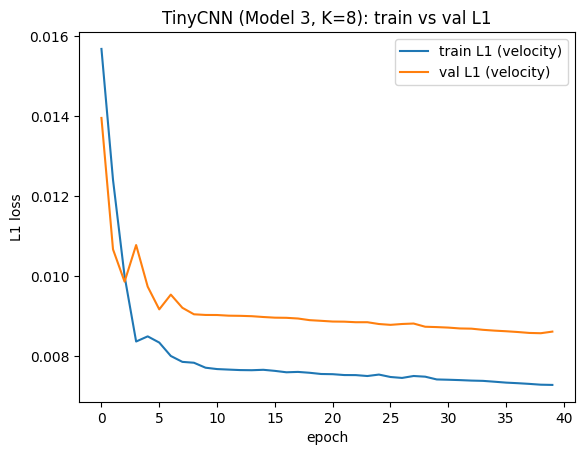

In [14]:
# early stopping

n_epochs3 = 40
patience = 5
best_val = float('inf')
best_state = None
epochs_no_improve = 0

hist_tr3, hist_val3 = [], []

for ep in range(1, n_epochs3 + 1):
    tr = train_epoch_vel(model3, tr_loader3)
    va = evaluate_vel(model3, val_loader3)
    hist_tr3.append(tr)
    hist_val3.append(va)

    if ep == 1 or ep % 5 == 0:
        print(f"[Model3 K={K3}] epoch {ep:02d} | train L1={tr:.5f} | val L1={va:.5f}")

    if va < best_val - 1e-6:
        best_val = va
        best_state = copy.deepcopy(model3.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"[Model3] Early stopping triggered at epoch {ep}")
            break

if best_state is not None:
    model3.load_state_dict(best_state)

val_L1_best = best_val
test_L1 = evaluate_vel(model3, te_loader3)
test_MSE_frame = evaluate_frame_mse(model3, te_loader3)

print(f"[Model3] best val L1 (velocity) = {val_L1_best:.5f}")
print(f"[Model3] test L1  (velocity) = {test_L1:.5f}")
print(f"[Model3] test MSE on predicted frame[t+1] = {test_MSE_frame:.5f}")

plt.figure()
plt.plot(hist_tr3, label="train L1 (velocity)")
plt.plot(hist_val3, label="val L1 (velocity)")
plt.xlabel("epoch")
plt.ylabel("L1 loss")
plt.title(f"TinyCNN (Model 3, K={K3}): train vs val L1")
plt.legend()
plt.show()

Example x3 shape: torch.Size([8, 1, 256, 256]) y3 shape: torch.Size([1, 256, 256])


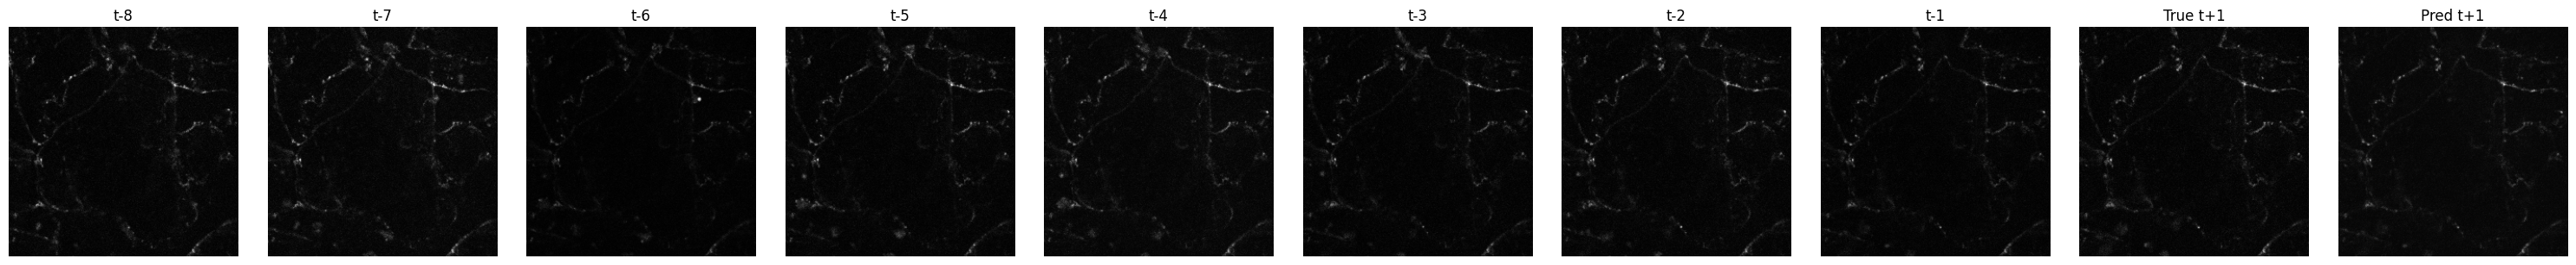

In [15]:

@torch.no_grad()
def show_example_vel(ds, model, idx=0, K=K3):
    model.eval()
    x, y = ds[idx]
    print("Example x3 shape:", x.shape, "y3 shape:", y.shape)

    x_in = x.unsqueeze(0).to(DEVICE)
    last_frame = x_in[:, -1, 0, :, :].unsqueeze(1)
    pred_vel = model(x_in)
    pred_frame = last_frame + pred_vel

    x_np = x.numpy()[:, 0, :, :]
    y_np = y.numpy()[0, :, :]
    pred_np = pred_frame.cpu().numpy()[0, 0, :, :]

    n_cols = K + 2
    fig, axes = plt.subplots(1, n_cols, figsize=(3 * n_cols, 3))
    for i in range(K):
        axes[i].imshow(x_np[i], cmap="gray")
        axes[i].set_title(f"t-{K-i}")
        axes[i].axis("off")

    axes[K].imshow(y_np, cmap="gray")
    axes[K].set_title("True t+1")
    axes[K].axis("off")

    axes[K+1].imshow(pred_np, cmap="gray")
    axes[K+1].set_title("Pred t+1")
    axes[K+1].axis("off")

    plt.tight_layout()
    plt.show()

show_example_vel(ds3, model3, idx=3, K=K3)

### Outputs for Model 3
Train and validation curves are close and converge smoothly, with no divergence. A test L1 < 0.01 means that, in normalized intensity space, the average per pixel error in the predicted velocity is on the order of 1% of the intensity scale. On that scale, MSE = 11 implies that the average squared error per pixel is very small compared with the full dynamic range.

The predicted next frame broadly matches the true one in overall intensity patterns. Some thin filaments and tiny bright spots are slightly blurred or shifted, which is expected since L1 focuses on average error rather than perfect pixel-wise matching.

## Comparison

In [16]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# aggregation center

def center_of_mass_2d(img: torch.Tensor, eps: float = 1e-8):
    if img.dim() == 3:
        img = img[0]
    img = img.float()
    H, W = img.shape

    y = torch.arange(H, device=img.device).view(H, 1).expand(H, W)
    x = torch.arange(W, device=img.device).view(1, W).expand(H, W)

    mass = img.sum() + eps
    cx = (img * x).sum() / mass
    cy = (img * y).sum() / mass
    return cx.item(), cy.item()



@torch.no_grad()
def evaluate_frame_model(model, loader, device):
    model.eval()
    mse_loss = torch.nn.MSELoss(reduction="sum")

    total_mse = 0.0
    n_samples = 0
    center_dists = []

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)

        # MSE
        batch_mse = mse_loss(pred, yb).item()
        total_mse += batch_mse
        n_samples += xb.size(0)

        # center error
        for i in range(xb.size(0)):
            true_frame = yb[i, 0].cpu()
            pred_frame = pred[i, 0].cpu()
            cx_true, cy_true = center_of_mass_2d(true_frame)
            cx_pred, cy_pred = center_of_mass_2d(pred_frame)
            dist = np.sqrt((cx_true - cx_pred) ** 2 + (cy_true - cy_pred) ** 2)
            center_dists.append(dist)

    n_pixels = yb[0].numel()
    mse_mean = total_mse / (n_samples * n_pixels)
    return mse_mean, center_dists



@torch.no_grad()
def evaluate_velocity_model(model, loader, device):
    model.eval()
    l1_loss = torch.nn.L1Loss(reduction="sum")
    mse_loss = torch.nn.MSELoss(reduction="sum")

    total_l1 = 0.0
    total_mse = 0.0
    n_samples = 0
    center_dists = []

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        # last frame t
        last_frame = xb[:, -1, 0, :, :].unsqueeze(1)
        true_next = yb
        target_vel = true_next - last_frame

        # predict velocity
        v_pred = model(xb)

        # L1 on velocity
        batch_l1 = l1_loss(v_pred, target_vel).item()
        total_l1 += batch_l1

        # reconstructed t+1
        pred_next = last_frame + v_pred

        # MSE on reconstructed t+1
        batch_mse = mse_loss(pred_next, true_next).item()
        total_mse += batch_mse
        n_samples += xb.size(0)

        # center error
        for i in range(xb.size(0)):
            true_frame = true_next[i, 0].cpu()
            pred_frame = pred_next[i, 0].cpu()
            cx_true, cy_true = center_of_mass_2d(true_frame)
            cx_pred, cy_pred = center_of_mass_2d(pred_frame)
            dist = np.sqrt((cx_true - cx_pred) ** 2 + (cy_true - cy_pred) ** 2)
            center_dists.append(dist)

    n_pixels = true_next[0].numel()
    mean_l1 = total_l1 / (n_samples * n_pixels)
    mean_mse = total_mse / (n_samples * n_pixels)
    return mean_l1, mean_mse, center_dists


# CI

def mean_and_ci(arr, alpha=0.95):
    arr = np.asarray(arr)
    mean = arr.mean()
    std = arr.std(ddof=1)
    n = arr.size
    z = 1.96
    ci = z * std / np.sqrt(n)
    return mean, ci


def plot_example_with_centers(model, dataset, idx, K, device, velocity=False):
    model.eval()
    x, y = dataset[idx]
    x_dev = x.unsqueeze(0).to(device)

    with torch.no_grad():
        if not velocity:
            pred = model(x_dev)[0, 0].cpu()
            true_next = y[0].cpu()
        else:
            v_pred = model(x_dev)[0, 0]
            last_frame = x_dev[0, -1, 0]
            pred = (last_frame + v_pred).cpu()
            true_next = y[0].cpu()

    cx_true, cy_true = center_of_mass_2d(true_next)
    cx_pred, cy_pred = center_of_mass_2d(pred)

    n_cols = K + 2
    plt.figure(figsize=(3 * n_cols, 3))

    for i in range(K):
        ax = plt.subplot(1, n_cols, i + 1)
        img = x[i, 0].cpu()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"t-{K-i}")
        ax.axis("off")

    # true t+1
    ax = plt.subplot(1, n_cols, K + 1)
    ax.imshow(true_next, cmap="gray")
    ax.scatter([cx_true], [cy_true], c="lime", s=40, label="True center")
    ax.set_title("True t+1")
    ax.axis("off")

    # predicted t+1
    ax = plt.subplot(1, n_cols, K + 2)
    ax.imshow(pred, cmap="gray")
    ax.scatter([cx_pred], [cy_pred], c="red", s=40, label="Pred center")
    ax.set_title("Pred t+1")
    ax.axis("off")

    plt.tight_layout()
    plt.show()


# Error vs. center distance

def plot_error_vs_K(K_list, perK_center_errors, title="Error vs. available frames"):
    means = [np.mean(perK_center_errors[K]) for K in K_list]

    plt.figure(figsize=(5, 4))
    plt.plot(K_list, means, marker="o")
    plt.xlabel("Number of input frames K")
    plt.ylabel("Mean center error (pixels)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

                          Model  K (frames)  Test MSE on t+1  \
0     Model 1: K=4, frame→frame           4         0.000127   
1     Model 2: K=8, frame→frame           8         0.000158   
2  Model 3: K=8, velocity→frame           8         0.000160   

   Test L1 on velocity  Center error mean (px)  Center error 95% CI (±px)  
0                  NaN                1.198821                   0.389822  
1                  NaN                2.534327                   1.007541  
2             0.006574                1.571061                   0.673981  
Model 1 example (K=4, frame→frame)


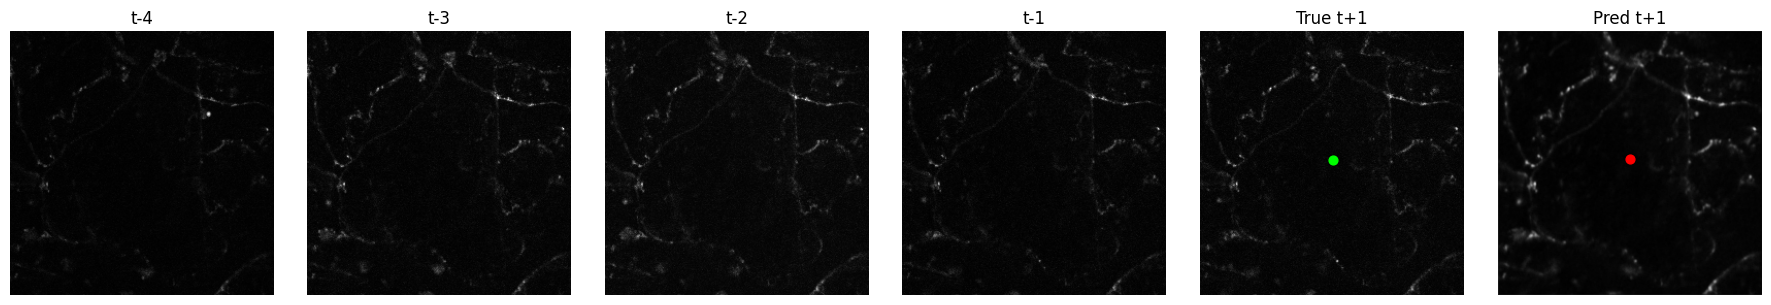

Model 2 example (K=8, frame→frame)


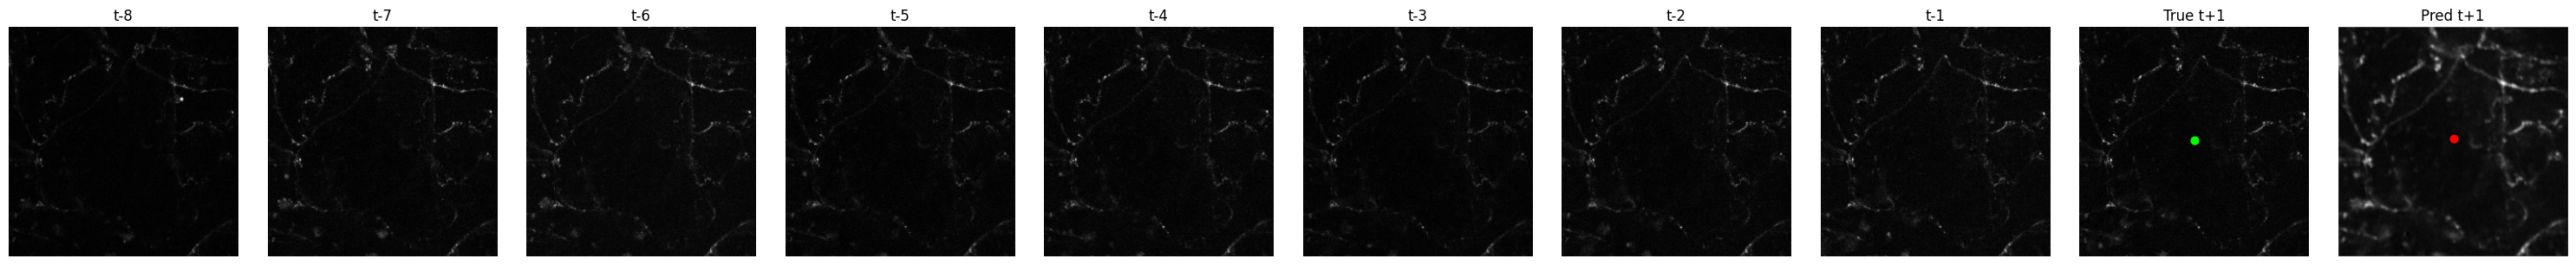

Model 3 example (K=8, velocity→frame)


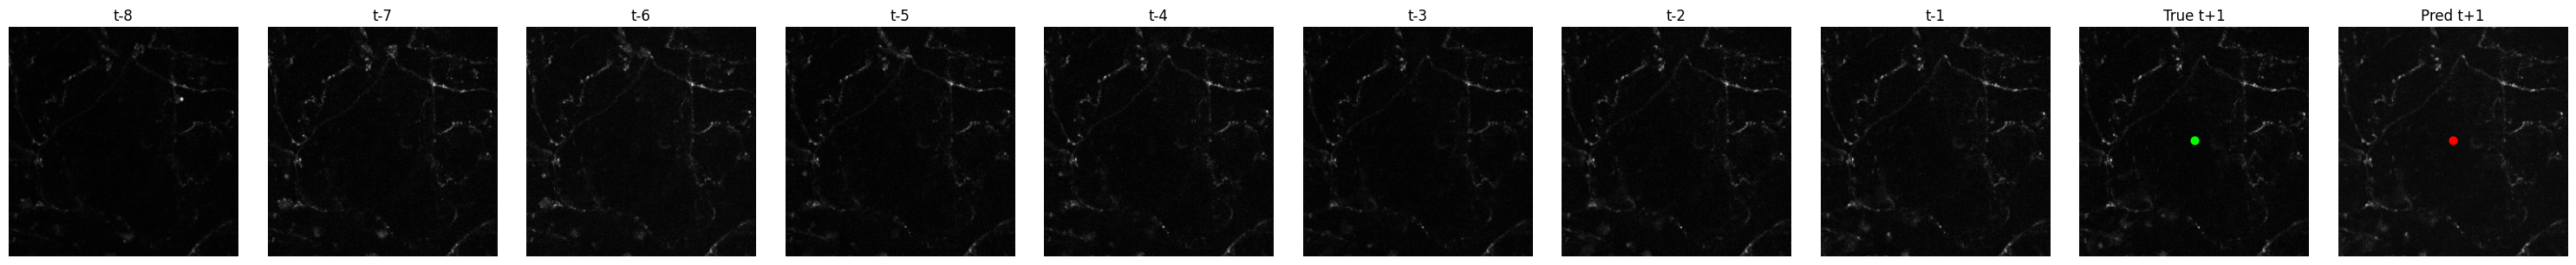

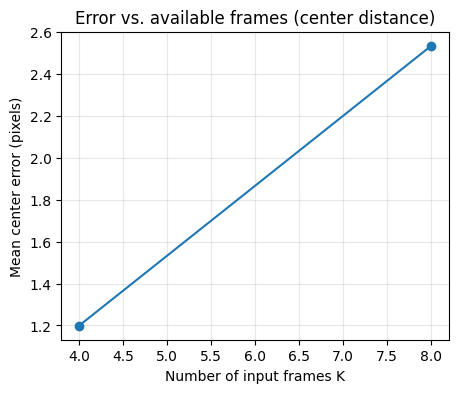

In [17]:
# Model 1: K=4, frame -> frame[t+1]
test_mse_1, center_dists_1 = evaluate_frame_model(model1, te_loader, DEVICE)

# Model 2: K=8, frame -> frame[t+1]
test_mse_2, center_dists_2 = evaluate_frame_model(model2, test2_loader, DEVICE)

# Model 3: K=8, velocity + reconstructed frame[t+1]
test_l1_3, test_mse_3, center_dists_3 = evaluate_velocity_model(model3, te_loader3, DEVICE)

# center error
center_mean_1, center_ci_1 = mean_and_ci(center_dists_1)
center_mean_2, center_ci_2 = mean_and_ci(center_dists_2)
center_mean_3, center_ci_3 = mean_and_ci(center_dists_3)


# metrics table（mean ± CI）

metrics_df = pd.DataFrame({
    "Model": [
        "Model 1: K=4, frame→frame",
        "Model 2: K=8, frame→frame",
        "Model 3: K=8, velocity→frame"
    ],
    "K (frames)": [4, 8, 8],
    "Test MSE on t+1": [test_mse_1, test_mse_2, test_mse_3],
    "Test L1 on velocity": [np.nan, np.nan, test_l1_3],
    "Center error mean (px)": [center_mean_1, center_mean_2, center_mean_3],
    "Center error 95% CI (±px)": [center_ci_1, center_ci_2, center_ci_3]
})

print(metrics_df)



# Figure 1: Early frames with predicted hotspot/center overlaid

example_idx = 5

print("Model 1 example (K=4, frame→frame)")
plot_example_with_centers(model1, ds,  idx=example_idx, K=4, device=DEVICE, velocity=False)

print("Model 2 example (K=8, frame→frame)")
plot_example_with_centers(model2, ds2, idx=example_idx, K=8, device=DEVICE, velocity=False)

print("Model 3 example (K=8, velocity→frame)")
plot_example_with_centers(model3, ds3, idx=example_idx, K=8, device=DEVICE, velocity=True)



# Figure 2: Error vs. available frames

K_list = [4, 8]
perK_center_errors = {
    4: center_dists_1,
    8: center_dists_2
}

plot_error_vs_K(
    K_list,
    perK_center_errors,
    title="Error vs. available frames (center distance)"
)


## Bonus

In [18]:
# Bonus: simplified DYffusion-style model

import math, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
try:
    DEVICE
except NameError:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Diffusion model device:", DEVICE)


K_diff = 8

ds_diff = MultiMovieWindows(movies, K=K_diff, stride=1)

N = len(ds_diff)
n_train = int(0.7 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

g = torch.Generator().manual_seed(0)
tr_diff, val_diff, te_diff = torch.utils.data.random_split(
    ds_diff, [n_train, n_val, n_test], generator=g
)

BATCH_DIFF = 8
tr_diff_loader  = DataLoader(tr_diff, batch_size=BATCH_DIFF, shuffle=True)
val_diff_loader = DataLoader(val_diff, batch_size=BATCH_DIFF, shuffle=False)
te_diff_loader  = DataLoader(te_diff, batch_size=BATCH_DIFF, shuffle=False)

xb, yb = next(iter(tr_diff_loader))
print("Diffusion batch shapes:",
      "x:", xb.shape,
      "y:", yb.shape)



# Diffusion schedule

class DiffusionSchedule:
    def __init__(self, T=100, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.T = T
        self.device = device
        betas = torch.linspace(beta_start, beta_end, T, device=device)
        self.betas = betas
        self.alphas = 1.0 - betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        a_bar = self.alpha_bar[t].view(-1, 1, 1, 1)
        return torch.sqrt(a_bar) * x0 + torch.sqrt(1.0 - a_bar) * noise

    def p_sample(self, model, x_t, context, t):
        eps = model(torch.cat([x_t, context], dim=1), t)

        beta_t = self.betas[t].view(-1, 1, 1, 1)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
        sqrt_one_minus_ab = torch.sqrt(1.0 - alpha_bar_t)

        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - beta_t / sqrt_one_minus_ab * eps
        )

        noise = torch.randn_like(x_t)
        nonzero_mask = (t > 0).float().view(-1, 1, 1, 1)
        return mean + nonzero_mask * torch.sqrt(beta_t) * noise

    def p_sample_loop(self, model, context, shape):
        B = shape[0]
        x_t = torch.randn(shape, device=self.device)
        for t_step in reversed(range(self.T)):
            t = torch.full((B,), t_step, device=self.device, dtype=torch.long)
            x_t = self.p_sample(model, x_t, context, t)
        return x_t


# Simple U-Net with time embedding

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.time_mlp = None
        if time_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_dim, out_ch),
            )

    def forward(self, x, t_emb=None):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h)
        if self.time_mlp is not None and t_emb is not None:
            cond = self.time_mlp(t_emb)[:, :, None, None]
            h = h + cond
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h)
        return h


class SimpleUNet(nn.Module):
    def __init__(self, in_ch, base_ch=32, time_dim=128):
        super().__init__()
        self.time_dim = time_dim

        self.inc = ConvBlock(in_ch, base_ch, time_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch * 2, 4, stride=2, padding=1)
        self.block1 = ConvBlock(base_ch * 2, base_ch * 2, time_dim)
        self.down2 = nn.Conv2d(base_ch * 2, base_ch * 4, 4, stride=2, padding=1)
        self.block2 = ConvBlock(base_ch * 4, base_ch * 4, time_dim)

        self.up1 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 4, stride=2, padding=1)
        self.ublock1 = ConvBlock(base_ch * 4, base_ch * 2, time_dim)
        self.up2 = nn.ConvTranspose2d(base_ch * 2, base_ch, 4, stride=2, padding=1)
        self.ublock2 = ConvBlock(base_ch * 2, base_ch, time_dim)

        self.outc = nn.Conv2d(base_ch, 1, 1)

    def pos_encoding(self, t):
        half = self.time_dim // 2
        device = t.device
        emb_scale = torch.log(torch.tensor(10000.0, device=device)) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb_scale)
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

    def forward(self, x, t):
        t_emb = self.pos_encoding(t)
        x1 = self.inc(x, t_emb)
        x2 = self.down1(x1)
        x2 = self.block1(x2, t_emb)
        x3 = self.down2(x2)
        x3 = self.block2(x3, t_emb)
        u1 = self.up1(x3)
        u1 = torch.cat([u1, x2], dim=1)
        u1 = self.ublock1(u1, t_emb)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, x1], dim=1)
        u2 = self.ublock2(u2, t_emb)
        out = self.outc(u2)
        return out


# Instantiate model + schedule

diff_schedule = DiffusionSchedule(T=100, device=DEVICE)
diff_model = SimpleUNet(in_ch=1 + K_diff, base_ch=32, time_dim=128).to(DEVICE)

optimizer_diff = torch.optim.Adam(diff_model.parameters(), lr=1e-4)

print(diff_model)


# 5. Training loop

def train_diffusion_epoch(model, schedule, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        B, K, C, H, W = xb.shape
        assert K == K_diff and C == 1
        context = xb.view(B, K, H, W)
        target  = yb

        t = torch.randint(
            low=0, high=schedule.T, size=(B,), device=device, dtype=torch.long
        )
        noise = torch.randn_like(target)

        x_t = schedule.q_sample(target, t, noise)
        model_in = torch.cat([x_t, context], dim=1)

        eps_pred = model(model_in, t)

        loss = F.mse_loss(eps_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B

    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_diffusion_epoch(model, schedule, loader, device):
    model.eval()
    total_loss = 0.0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        B, K, C, H, W = xb.shape
        context = xb.view(B, K, H, W)
        target = yb

        t = torch.randint(
            low=0, high=schedule.T, size=(B,), device=device, dtype=torch.long
        )
        noise = torch.randn_like(target)
        x_t = schedule.q_sample(target, t, noise)

        model_in = torch.cat([x_t, context], dim=1)
        eps_pred = model(model_in, t)
        loss = F.mse_loss(eps_pred, noise)

        total_loss += loss.item() * B

    return total_loss / len(loader.dataset)



n_epochs_diff = 10
for ep in range(1, n_epochs_diff + 1):
    tr_loss = train_diffusion_epoch(diff_model, diff_schedule,
                                    tr_diff_loader, optimizer_diff, DEVICE)
    val_loss = eval_diffusion_epoch(diff_model, diff_schedule,
                                    val_diff_loader, DEVICE)
    if ep == 1 or ep % 2 == 0:
        print(f"[Diffusion] epoch {ep:02d} | train loss={tr_loss:.5f} "
              f"| val loss={val_loss:.5f}")


Diffusion model device: cuda
Total sliding windows in dataset: 70
Diffusion batch shapes: x: torch.Size([8, 8, 1, 256, 256]) y: torch.Size([8, 1, 256, 256])
SimpleUNet(
  (inc): ConvBlock(
    (conv1): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (down1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (block1): ConvBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Line

In [19]:
@torch.no_grad()
def sample_forecast_from_batch(model, schedule, xb, n_samples=4, device=DEVICE):
    xb = xb.to(device)
    B, K, C, H, W = xb.shape
    context = xb.view(B, K, H, W)

    preds = []
    for _ in range(n_samples):
        x_t = torch.randn(B, 1, H, W, device=device)
        for t_step in reversed(range(schedule.T)):
            t = torch.full((B,), t_step, device=device, dtype=torch.long)
            x_t = schedule.p_sample(model, x_t, context, t)
        preds.append(x_t.cpu())

    all_preds = torch.stack(preds, dim=0)
    mean_pred = all_preds.mean(dim=0)
    return mean_pred, all_preds

xb_test, yb_test = next(iter(te_diff_loader))
mean_pred, all_preds = sample_forecast_from_batch(
    diff_model, diff_schedule, xb_test[:1], n_samples=4, device=DEVICE
)

print("Sampled prediction shape:", mean_pred.shape)

Sampled prediction shape: torch.Size([1, 1, 256, 256])


True center: (122.5, 125.0)
Pred  center: (127.3, 127.1)


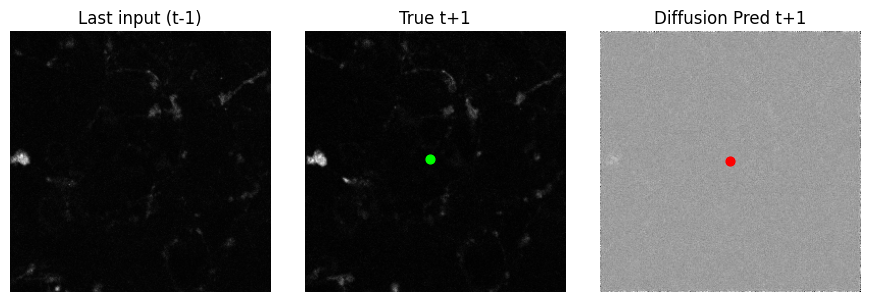

In [20]:
import matplotlib.pyplot as plt

x_seq     = xb_test[0]
true_next = yb_test[0, 0].cpu()
pred_next = mean_pred[0, 0].cpu()

# aggregation center
cx_true, cy_true = center_of_mass_2d(true_next)
cx_pred, cy_pred = center_of_mass_2d(pred_next)

print(f"True center: ({cx_true:.1f}, {cy_true:.1f})")
print(f"Pred  center: ({cx_pred:.1f}, {cy_pred:.1f})")

plt.figure(figsize=(9, 3))

ax = plt.subplot(1, 3, 1)
ax.imshow(x_seq[-1, 0].cpu(), cmap="gray")
ax.set_title("Last input (t-1)")
ax.axis("off")

# True t+1
ax = plt.subplot(1, 3, 2)
ax.imshow(true_next, cmap="gray")
ax.scatter([cx_true], [cy_true], c="lime", s=40, label="True center")
ax.set_title("True t+1")
ax.axis("off")

# Predicted t+1
ax = plt.subplot(1, 3, 3)
ax.imshow(pred_next, cmap="gray")
ax.scatter([cx_pred], [cy_pred], c="red", s=40, label="Pred center")
ax.set_title("Diffusion Pred t+1")
ax.axis("off")

plt.tight_layout()
plt.show()
